In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("mbd-prj").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/05 17:46:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/05 17:46:32 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Reading the datasets

In [2]:
from pathlib import Path
lymsys_folder = Path("/Users/lgk1910/Library/CloudStorage/OneDrive-AaltoUniversity/Learning2/Big Data/Project/data/lmsys-chat-1m")
wildchat_folder = Path("/Users/lgk1910/Library/CloudStorage/OneDrive-AaltoUniversity/Learning2/Big Data/Project/data/WildChat-1M-Full/WildChat-1M-Full/")

In [3]:
# test reading the dataset from a folder of parquet files
lymsys_df = spark.read.parquet(str(lymsys_folder))
lymsys_df.show(5)
wildchat_df = spark.read.parquet(str(wildchat_folder))
wildchat_df.show(5)


+--------------------+----------+-----------------------------------+----+----------+--------------------+--------+
|     conversation_id|     model|                       conversation|turn|  language|   openai_moderation|redacted|
+--------------------+----------+-----------------------------------+----+----------+--------------------+--------+
|c20948192699451b8...|vicuna-13b|               [{Given the artic...|   1|   English|[{{false, false, ...|    true|
|8b02aa2df44847a1b...|vicuna-33b|               [{Alright, let's ...|   2|   English|[{{false, false, ...|    true|
|c18f3612fac140cb9...|vicuna-13b|[{あなたが最終更新されたのはいつ...|   5|  Japanese|[{{false, false, ...|   false|
|d1fabb62e3364665a...| llama-13b|               [{You are an AI a...|   1|   English|[{{false, false, ...|    true|
|b2da335248f04e439...| koala-13b|               [{Reescreva esse ...|   1|Portuguese|[{{false, false, ...|   false|
+--------------------+----------+-----------------------------------+----+----------+--

# Sample codes

In [4]:
# take the column 'conversation' from the first row of the dataframe, convert it to a list
lym_conv_sample = lymsys_df.select('conversation').first().conversation
print(lym_conv_sample[0].asDict().keys())
wild_conv_sample = wildchat_df.select('conversation').first().conversation
print(wild_conv_sample[0].asDict().keys())

dict_keys(['content', 'role'])
dict_keys(['content', 'country', 'hashed_ip', 'header', 'language', 'redacted', 'role', 'state', 'timestamp', 'toxic', 'turn_identifier'])


In [7]:
wildchat_df.select('header').first().header


Row(accept-language='en-US,en;q=0.9', user-agent='Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36')

In [9]:
wildchat_df.filter(wildchat_df.header['user-agent'] == 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36').count()


28341

In [6]:
# search all rows with hashed_ip = 'f96c8515aa663db23ee086f36b7d3642036d5394bbbeada3fe0c6c8285f4d314'
wild_ip = 'f96c8515aa663db23ee086f36b7d3642036d5394bbbeada3fe0c6c8285f4d314'
wild_ip_df = wildchat_df.filter(col('hashed_ip') == wild_ip)
wild_ip_df.show(5)


+--------------------+------------------+-------------------+--------------------+----+--------+--------------------+--------------------+-----+--------+--------+-------------+--------------------+--------------------+
|   conversation_hash|             model|          timestamp|        conversation|turn|language|   openai_moderation| detoxify_moderation|toxic|redacted|   state|      country|           hashed_ip|              header|
+--------------------+------------------+-------------------+--------------------+----+--------+--------------------+--------------------+-----+--------+--------+-------------+--------------------+--------------------+
|f01a345e668b978b6...|gpt-3.5-turbo-0613|2023-09-13 04:14:27|[{(In the clubroo...|   1| English|[{{false, false, ...|[{2.1957975695841...|false|   false|Michigan|United States|f96c8515aa663db23...|{en-US,en;q=0.9, ...|
|136971e6080d62e86...|gpt-3.5-turbo-0613|2023-09-13 09:40:52|[{(In the clubroo...|   1| English|[{{false, false, ...|[{2.195

In [10]:
# count number of unique conversation_id in lymsys_df
lym_conv_count = lymsys_df.select('conversation_id').distinct().count()
print(lym_conv_count)
# number of rows
lym_row_count = lymsys_df.count()
print(lym_row_count)

1000000
1000000


## Question 1: What percentage of users have multiple conversations?
- WildChat: Use combination of `hashed_ip` and `header` to estimate number of repeat users

In [34]:
from pyspark.sql.functions import col, count, countDistinct, when, concat
from matplotlib import pyplot as plt
import numpy as np

In [14]:
# count number of users, group by hashed_ip and header.user-agent
wild_user_count = wildchat_df.groupBy('hashed_ip', 'header.user-agent').count()
print(f'{wild_user_count.count() = }')
# count number of users, group by hashed_ip only
wild_user_count = wildchat_df.groupBy('hashed_ip').count()
print(f'{wild_user_count.count() = }')


wild_user_count.count() = 241796


wild_user_count.count() = 188517


In [22]:
# 1. Create analysis on composite_key (already created in cell 14)
wildchat_df = wildchat_df.withColumn(
    "composite_key",
    concat(col("hashed_ip"), F.lit("_"), col("header.user-agent"))
)

# 2. Count conversations per unique user
user_conversation_counts = wildchat_df.groupBy("composite_key").agg(
	count("conversation_hash").alias("conversation_count")
)

# 3. Calculate statistics
total_users = user_conversation_counts.count()
repeat_users = user_conversation_counts.filter(col("conversation_count") > 1).count()
repeat_percentage = (repeat_users / total_users) * 100

# 4. Show results
print(f"Total unique users: {total_users}")
print(f"Users with multiple conversations: {repeat_users}")
print(f"Percentage of repeat users: {repeat_percentage:.2f}%")


Total unique users: 241217
Users with multiple conversations: 101090
Percentage of repeat users: 41.91%


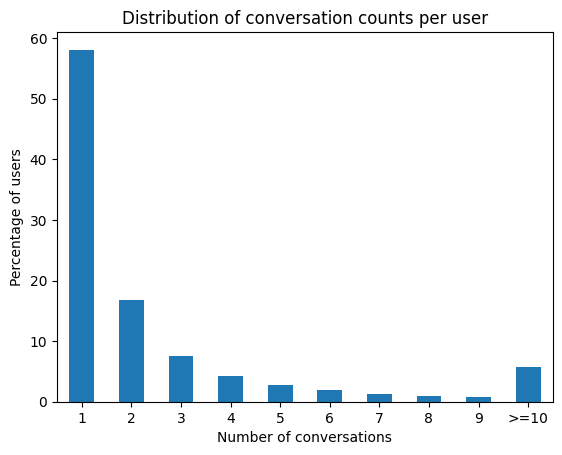

   conversation_count  user_count  percentage
0                   1      140127   58.091677
1                   2       40394   16.745918
2                   3       18165    7.530564
3                   4       10174    4.217779
4                   5        6551    2.715812
5                   6        4550    1.886268
6                   7        3253    1.348578
7                   8        2460    1.019829
8                   9        1906    0.790160
9                  10       13637    5.653416


In [32]:
# 5. Optional: Distribution of conversation counts
user_conversation_counts_grouped = user_conversation_counts.groupBy("conversation_count") \
	.agg(count("*").alias("user_count")) \
	.orderBy("conversation_count") \

# 5.1. Group into bins
user_conversation_counts_grouped = user_conversation_counts_grouped.withColumn(
	"conversation_count",
	when(col("conversation_count") < 10, col("conversation_count")).otherwise(10)
)
user_conversation_counts_grouped = user_conversation_counts_grouped.groupBy("conversation_count") \
	.agg(F.sum("user_count").alias("user_count")) \
	.orderBy("conversation_count")

# 6. Plot distribution, plot in % scale
# Calculate total users for percentage
total = user_conversation_counts_grouped.agg(F.sum("user_count")).collect()[0][0]
# Convert to pandas and calculate percentage
df_plot = user_conversation_counts_grouped.toPandas()
df_plot['percentage'] = (df_plot['user_count'] / total) * 100
# Create the plot
df_plot.plot.bar(x="conversation_count", y="percentage", legend=False)
plt.xticks(range(10), [str(i) for i in range(1, 10)] + ['>=10'], rotation=0)  # Changed this line
plt.xlabel("Number of conversations")
plt.ylabel("Percentage of users")
plt.title("Distribution of conversation counts per user")
plt.show()
print(df_plot)

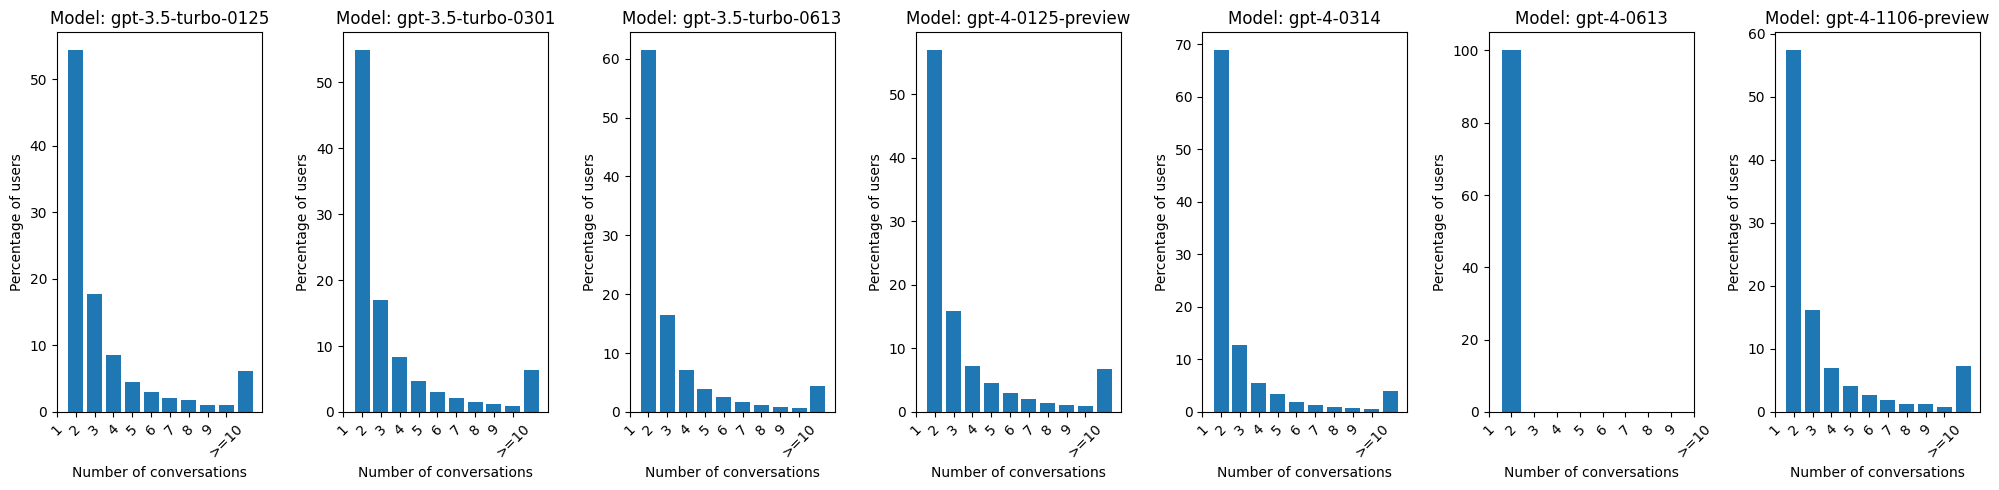

                 model  conversation_count  user_count  percentage
0   gpt-3.5-turbo-0125                   1        8649   54.314243
1   gpt-3.5-turbo-0125                   2        2813   17.665160
2   gpt-3.5-turbo-0125                   3        1356    8.515448
3   gpt-3.5-turbo-0125                   4         706    4.433559
4   gpt-3.5-turbo-0125                   5         476    2.989199
..                 ...                 ...         ...         ...
56  gpt-4-1106-preview                   6         443    1.869751
57  gpt-4-1106-preview                   7         311    1.312624
58  gpt-4-1106-preview                   8         302    1.274638
59  gpt-4-1106-preview                   9         200    0.844131
60  gpt-4-1106-preview                  10        1731    7.305955

[61 rows x 4 columns]


In [33]:
# Group by model and count conversations per user
model_user_counts = wildchat_df.groupBy("composite_key", "model").count()

# Create distribution per model 
model_conversation_counts = model_user_counts.groupBy("model", "count")\
	.agg(F.count("*").alias("user_count"))\
	.orderBy("model", "count")

# Group counts >= 10 together
model_conversation_counts = model_conversation_counts.withColumn(
	"conversation_count",
	when(col("count") < 10, col("count")).otherwise(10)
)

# Aggregate after grouping
model_conversation_counts = model_conversation_counts.groupBy("model", "conversation_count")\
	.agg(F.sum("user_count").alias("user_count"))\
	.orderBy("model", "conversation_count")

# Convert to pandas for easier plotting
model_df = model_conversation_counts.toPandas()

# Calculate percentages per model
model_df['percentage'] = model_df.groupby('model')['user_count'].transform(
	lambda x: (x / x.sum()) * 100
)

# Create subplots for each model
models = model_df['model'].unique()
fig, axes = plt.subplots(1, len(models), figsize=(20, 5))

for i, model in enumerate(models):
	model_data = model_df[model_df['model'] == model]
	axes[i].bar(model_data['conversation_count'], model_data['percentage'])
	axes[i].set_title(f'Model: {model}')
	axes[i].set_xlabel('Number of conversations')
	axes[i].set_ylabel('Percentage of users')
	axes[i].set_xticks(range(10))
	axes[i].set_xticklabels([str(i) for i in range(1, 10)] + ['>=10'], rotation=45)

plt.tight_layout()
plt.show()
print(model_df)

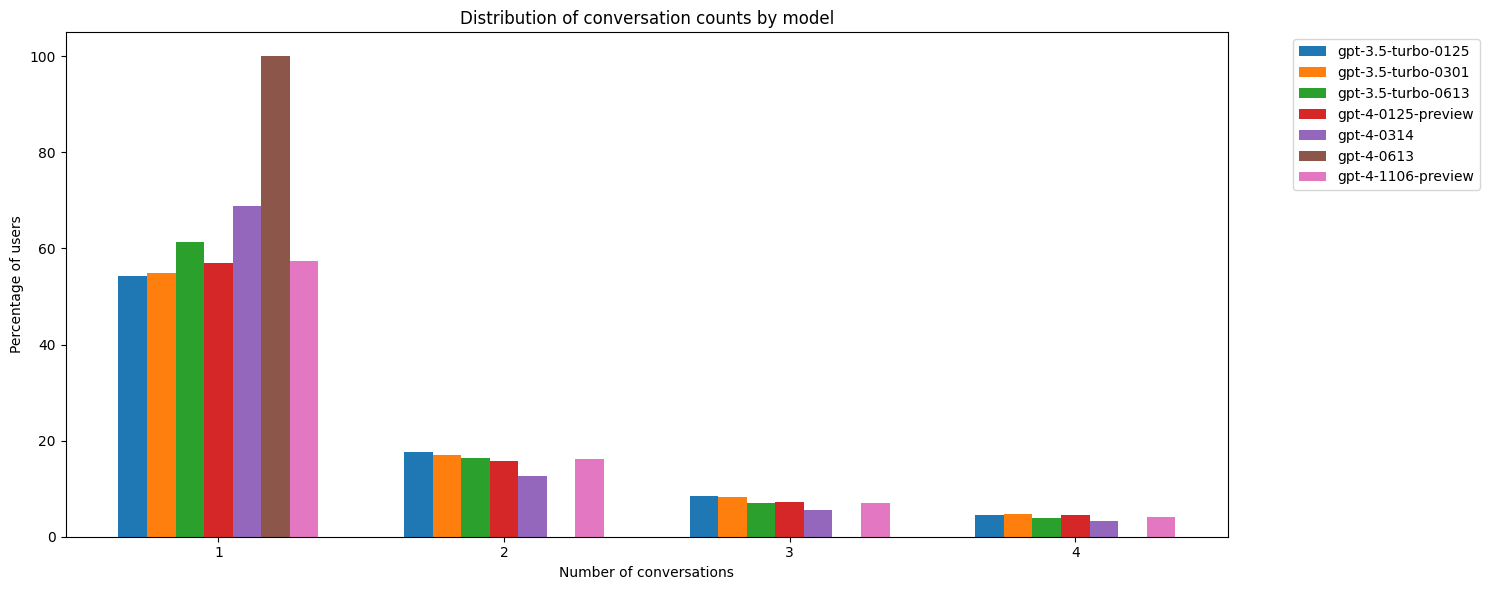

In [38]:
# Create a bar plot for conversation counts 1-4 across all models
conv_counts = [1, 2, 3, 4]
width = 0.1
x = np.arange(len(conv_counts))

plt.figure(figsize=(15, 6))

for i, model in enumerate(models):
	model_data = model_df[model_df['model'] == model]
	# Get only the rows with conversation_count in conv_counts
	model_data = model_data[model_data['conversation_count'].isin(conv_counts)]
	# Some models might not have all conversation counts, so we need to handle missing values
	percentages = []
	for count in conv_counts:
		matching_row = model_data[model_data['conversation_count'] == count]
		if len(matching_row) > 0:
			percentages.append(matching_row.iloc[0]['percentage'])
		else:
			percentages.append(0)
	
	plt.bar(x + i*width, percentages, width, label=model)

plt.xlabel('Number of conversations')
plt.ylabel('Percentage of users')
plt.title('Distribution of conversation counts by model')
plt.xticks(x + (len(models)-1)*width/2, conv_counts)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()